# 2.0 Data Cleaning, PreProcessing and EDA

In [324]:
# importing all of the usual suspects
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import os


pd.options.display.max_colwidth = 400


from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize


# Had to use this to install contractions
# import sys  
# !{sys.executable} -m pip install contractions
import contractions
from nltk.stem import WordNetLemmatizer

# 2.1 Cleaning

In [325]:

list_of_files = glob.glob('../data/*.csv')   # * means all, use *.csv if we needed specific format
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df = pd.read_csv(latest_file)
df.head(3)

../data\reddit_content_20220227-105531.csv


,Unnamed: 0,title,author,selftext,media_only,num_comments,subreddit,created_utc
0,0,Is there anyway to Trade US options in UK,yoghin,I can't find any platforms that offer US options as assets - only as CFDs.,False,0,options,1645974032
1,1,NVDA's short leg,listenless,"I bought 240-200 Jan 2023 bear puts spread on NVDA back in October 21. That wasn't my best trade, frankly there were much lower hanging fruits (some of which I shorted as well). \n\nNow my short leg is profitable, and now pondering whether I should close it. I would do so if I had a conviction that NVDA has at least -15% drop coming, which is not a stretch at all. \n\nAnyone has thoughts ab...",False,0,options,1645971541
2,2,Patrick Boyle breaks down tons of consequences of the sanctions on Russia's central bank -- there are literally hundreds of plays based on this analysis,professorfundamental,This video: \n\n[https://www.youtube.com/watch?v=3QlpTlz073k](https://www.youtube.com/watch?v=3QlpTlz073k)\n\nwas just posted Sunday morning UK time. It contains detailed analysis of companies and industries affected by sanctions on Russian banks. \n\nRemember before you buy or sell anything: all the world's expert traders and firms already know all this information and prices reflect this ...,False,0,options,1645955748


**Fill missing values**

In [326]:
df.isnull().sum()

Unnamed: 0        0
title             0
author            0
selftext        298
media_only        0
num_comments      0
subreddit         0
created_utc       0
dtype: int64

In [327]:
df['selftext'].fillna('', inplace=True)

**Dropping the "Unnamed: 0" column**

In [328]:
df.drop(columns=['Unnamed: 0'],inplace=True)

**Formatting the Title and Selftext**

In [329]:
df['title'].str.lower();
df['selftext'].str.lower();

**Mapping to create target column**

In [330]:
df['subreddit'] = df['subreddit'].map({"options":0 , "stocks":1 })

**Creating Title Length columns**

In [331]:
df['title_length'] = df['title'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()

**Creating Word Count Columns**

In [332]:
df['selftext_length'] = df['title'].str.len()
df['selftext_word_count'] = df['selftext'].str.split().str.len()

# 2.2 EDA

**2.2.1 Word Counts per Title**

In [333]:
# It seems like there ought to be a function we could create to generate this code.  If time allows, revisit.

print("**** MINIMUMS ****")
print(f"Minimum Title Word Count (r/Options): {round(df[df['subreddit']==0]['title_word_count'].min(),2)}")
print(f"Minimum Title Word Count (r/Stocks): {round(df[df['subreddit']==1]['title_word_count'].min(),2)}")
print("\n**** MAXIMUMS ****")
print(f"Maximum Title Word Count (r/Options): {round(df[df['subreddit']==0]['title_word_count'].max(),2)}")
print(f"Maximum Title Word Count (r/Stocks): {round(df[df['subreddit']==1]['title_word_count'].max(),2)}")
print("\n**** AVERAGES ****")
print(f"Average Title Word Count (r/Options): {round(df[df['subreddit']==0]['title_word_count'].mean(),2)}")
print(f"Average Title Word Count (r/Stocks): {round(df[df['subreddit']==1]['title_word_count'].mean(),2)}")

**** MINIMUMS ****
Minimum Title Word Count (r/Options): 1
Minimum Title Word Count (r/Stocks): 1

**** MAXIMUMS ****
Maximum Title Word Count (r/Options): 65
Maximum Title Word Count (r/Stocks): 32

**** AVERAGES ****
Average Title Word Count (r/Options): 9.05
Average Title Word Count (r/Stocks): 8.58


**2.2.2 Char Length per Title**

In [334]:

print("**** MINIMUMS ****")
print(f"Minimum Title Length (r/Options): {round(df[df['subreddit']==0]['title_length'].min(),2)}")
print(f"Minimum Title Length (r/Stocks): {round(df[df['subreddit']==1]['title_length'].min(),2)}")
print("\n**** MAXIMUMS ****")
print(f"Maximum Title Length (r/Options): {round(df[df['subreddit']==0]['title_length'].max(),2)}")
print(f"Maximum Title Length (r/Stocks): {round(df[df['subreddit']==1]['title_length'].max(),2)}")
print("\n**** AVERAGES ****")
print(f"Average Title Length (r/Options): {round(df[df['subreddit']==0]['title_length'].mean(),2)}")
print(f"Average Title Length (r/Stocks): {round(df[df['subreddit']==1]['title_length'].mean(),2)}")

**** MINIMUMS ****
Minimum Title Length (r/Options): 1
Minimum Title Length (r/Stocks): 12

**** MAXIMUMS ****
Maximum Title Length (r/Options): 300
Maximum Title Length (r/Stocks): 146

**** AVERAGES ****
Average Title Length (r/Options): 50.78
Average Title Length (r/Stocks): 48.75


**2.2.3 Word Count per Post**

In [335]:
print("**** MINIMUMS ****")
print(f"Minimum Word Count per Post (r/Options): {round(df[df['subreddit']==0]['selftext_word_count'].min(),2)}")
print(f"Minimum Word Count per Post (r/Stocks): {round(df[df['subreddit']==1]['selftext_word_count'].min(),2)}")
print("\n**** MAXIMUMS ****")
print(f"Maximum Word Count per Post (r/Options): {round(df[df['subreddit']==0]['selftext_word_count'].max(),2)}")
print(f"Maximum Word Count per Post (r/Stocks): {round(df[df['subreddit']==1]['selftext_word_count'].max(),2)}")
print("\n**** AVERAGES ****")
print(f"Average Word Count per Post (r/Options): {round(df[df['subreddit']==0]['selftext_word_count'].mean(),2)}")
print(f"Average Word Count per Post (r/Stocks): {round(df[df['subreddit']==1]['selftext_word_count'].mean(),2)}")

**** MINIMUMS ****
Minimum Word Count per Post (r/Options): 0
Minimum Word Count per Post (r/Stocks): 0

**** MAXIMUMS ****
Maximum Word Count per Post (r/Options): 2574
Maximum Word Count per Post (r/Stocks): 5777

**** AVERAGES ****
Average Word Count per Post (r/Options): 64.02
Average Word Count per Post (r/Stocks): 76.64


**2.2.4 Char Length per Post**

In [336]:
print("**** MINIMUMS ****")
print(f"Minimum Char Length per post (r/Options): {round(df[df['subreddit']==0]['selftext_length'].min(),2)}")
print(f"Minimum Char Length post (r/Stocks): {round(df[df['subreddit']==1]['selftext_length'].min(),2)}")
print("\n**** MAXIMUMS ****")
print(f"Maximum Char Length per post (r/Options): {round(df[df['subreddit']==0]['selftext_length'].max(),2)}")
print(f"Maximum Char Length per post (r/Stocks): {round(df[df['subreddit']==1]['selftext_length'].max(),2)}")

print("\n**** AVERAGES ****")
print(f"Average Char Length per post (r/Options): {round(df[df['subreddit']==0]['selftext_length'].mean(),2)}")
print(f"Average Char Length per post (r/Stocks): {round(df[df['subreddit']==1]['selftext_length'].mean(),2)}")

**** MINIMUMS ****
Minimum Char Length per post (r/Options): 1
Minimum Char Length post (r/Stocks): 12

**** MAXIMUMS ****
Maximum Char Length per post (r/Options): 300
Maximum Char Length per post (r/Stocks): 146

**** AVERAGES ****
Average Char Length per post (r/Options): 50.78
Average Char Length per post (r/Stocks): 48.75


**2.2.5 Comments per post**

In [337]:

print("**** MINIMUMS ****")
print(f"Minimum Comments per post (r/Options): {round(df[df['subreddit']==0]['num_comments'].min(),2)}")
print(f"Minimum Comments per post (r/Stocks): {round(df[df['subreddit']==1]['num_comments'].min(),2)}")
print("\n**** MAXIMUMS ****")
print(f"Maximum Comments per post (r/Options): {round(df[df['subreddit']==0]['num_comments'].max(),2)}")
print(f"Maximum Comments per post (r/Stocks): {round(df[df['subreddit']==1]['num_comments'].max(),2)}")

print("\n**** AVERAGES ****")
print(f"Average Comments per post (r/Options): {round(df[df['subreddit']==0]['num_comments'].mean(),2)}")
print(f"Average Comments per post (r/Stocks): {round(df[df['subreddit']==1]['num_comments'].mean(),2)}")

**** MINIMUMS ****
Minimum Comments per post (r/Options): 0
Minimum Comments per post (r/Stocks): 0

**** MAXIMUMS ****
Maximum Comments per post (r/Options): 171
Maximum Comments per post (r/Stocks): 21

**** AVERAGES ****
Average Comments per post (r/Options): 1.24
Average Comments per post (r/Stocks): 0.27


### 2.2.6 Visualizations

In [338]:
# ****  Previous Chart for future reference *****
# # Distibution of Word Counts
# plt.figure(figsize=(10,10))
# # plotting first histogram
# plt.hist(df[df['subreddit']==0]['title_word_count'],label='Options', alpha=1,)
# # plotting second histogram
# plt.hist(df[df['subreddit']==1]['title_word_count'],label='Stocks', alpha=.8,)
# # Showing the plot using plt.show()
# plt.legend()
# plt.show()

**Creating specific dataframes to make visuals easier to create**

In [339]:
options = df[df['subreddit']==0]
stocks = df[df['subreddit']==1]

**Distibution of Title Word Counts by subreddit**

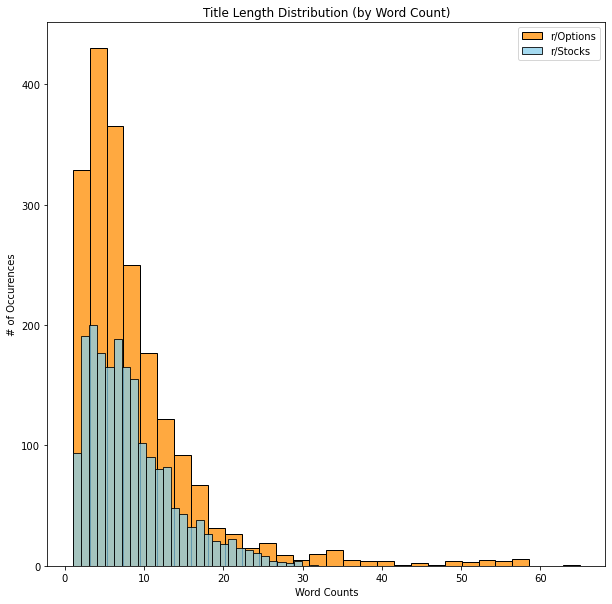

In [340]:
plt.figure(figsize=(10,10))

sns.histplot(data=options,bins = 30, x="title_word_count", color='darkorange',label='r/Options').set(title='Title Length Distribution (by Word Count)',xlabel='Word Counts',ylabel='# of Occurences')
sns.histplot(data=stocks, bins =30, x="title_word_count", color='skyblue',label='r/Stocks')

plt.legend()
plt.show();

**Distibution of Title Char Length by subreddit**

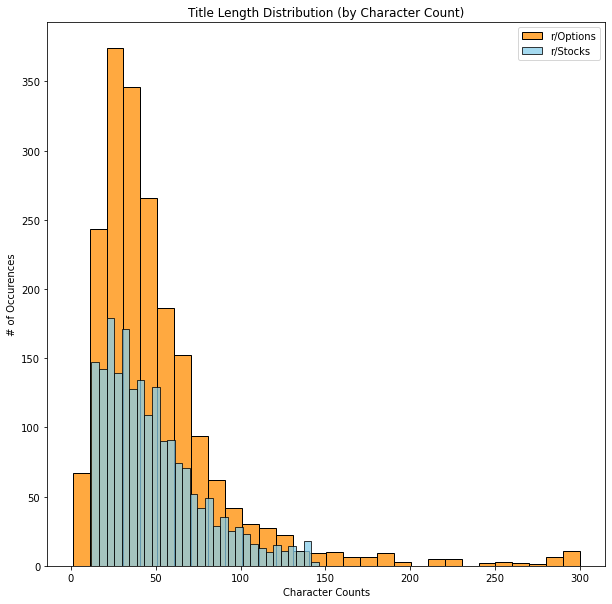

In [341]:
plt.figure(figsize=(10,10))

sns.histplot(data=options,bins = 30, x="title_length", color='darkorange',label='r/Options').set(title='Title Length Distribution (by Character Count)',xlabel='Character Counts',ylabel='# of Occurences')
sns.histplot(data=stocks, bins =30, x="title_length", color='skyblue',label='r/Stocks')

plt.legend()
plt.show();

**Distibution of Post Word Counts by subreddit**

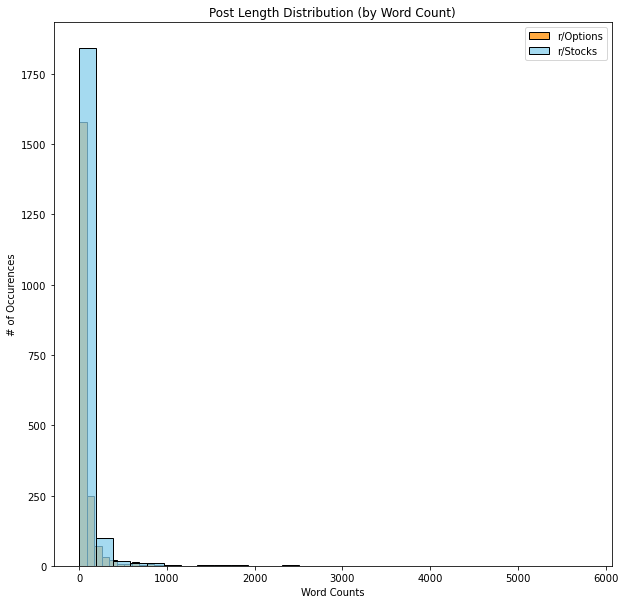

In [342]:
plt.figure(figsize=(10,10))

sns.histplot(data=options,bins = 30, x="selftext_word_count", color='darkorange',label='r/Options').set(title='Post Length Distribution (by Word Count)',xlabel='Word Counts',ylabel='# of Occurences')
sns.histplot(data=stocks, bins =30, x="selftext_word_count", color='skyblue',label='r/Stocks')

plt.legend()
plt.show();

**Distibution of Post Char Length by subreddit**

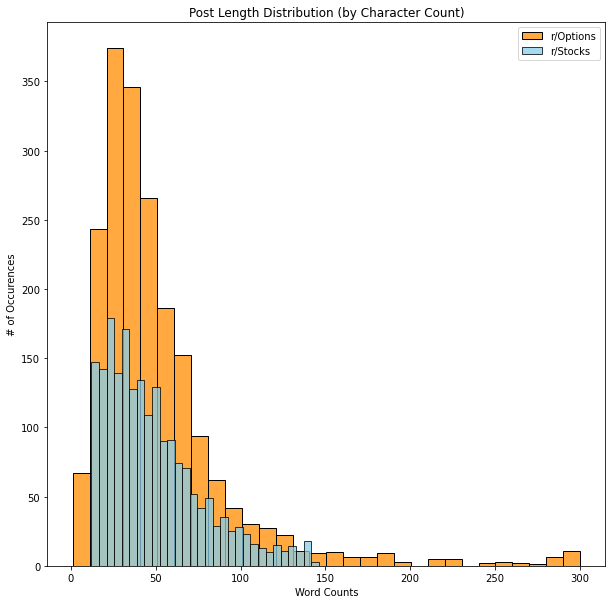

In [343]:
plt.figure(figsize=(10,10))

sns.histplot(data=options,bins = 30, x="selftext_length", color='darkorange',label='r/Options').set(title='Post Length Distribution (by Character Count)',xlabel='Word Counts',ylabel='# of Occurences')
sns.histplot(data=stocks, bins =30, x="selftext_length", color='skyblue',label='r/Stocks')

plt.legend()
plt.show();

**Distibution of Comments by subreddit**

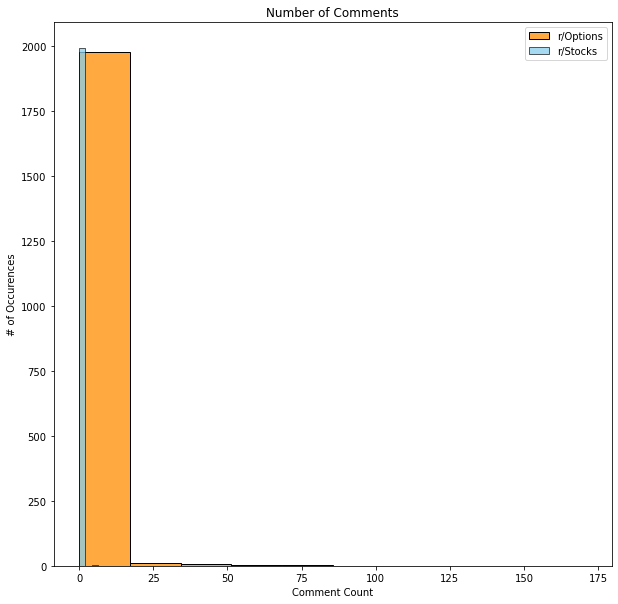

In [344]:
plt.figure(figsize=(10,10))

sns.histplot(data=options,bins = 10, x="num_comments", color='darkorange',label='r/Options').set(title='Number of Comments',xlabel='Comment Count',ylabel='# of Occurences')
sns.histplot(data=stocks, bins =10, x="num_comments", color='skyblue',label='r/Stocks')

plt.legend()
plt.show();

### 2.2.7 Posts over time and Author metrics

**Posts over time by subreddit**

In [345]:
#Options time span, 2000 posts pver the course of 42 days
pd.to_datetime(df[df['subreddit']==0]['created_utc'].max(), unit='s') - pd.to_datetime(df[df['subreddit']==0]['created_utc'].min(), unit='s')
#with help from https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

Timedelta('42 days 03:24:53')

In [346]:
#Stocks time span,  2000 posts pver the course of 15 days
pd.to_datetime(df[df['subreddit']==1]['created_utc'].max(), unit='s') - pd.to_datetime(df[df['subreddit']==1]['created_utc'].min(), unit='s')

Timedelta('15 days 13:09:58')

**Unique Authors**

In [347]:
# of unique authors
len(pd.unique(df['author']))

2909

In [348]:
# of unique authors by subreddit
print (df.groupby('subreddit')['author'].nunique())

subreddit
0    1415
1    1551
Name: author, dtype: int64


In [349]:
# Across 4000 posts, there are only 2909 unique users, so roughly 100 users are posting repeatedly on one or both for the subreddits. About 3.4%
# when broken down by subreddit, there are about 57 users who are posting on both subreddits   (2966 - 2909), about 1.9% 

**Author Stats**

Given more time, I would like to dive in deeper in to these and attempt to determine is there is any sort of 
correlation between the authors, the selftext (post) word count, and the number of comments per post.  
My hypothesis is that some authors are more knowledgable and engaging.  Those might be people we want to track.
Those that are more knowledgable may also be more likely to stocks/options and correctly reflect the direction 
that those commodities will be moving.

In [350]:
df.groupby('author')['title_length', 'title_word_count','num_comments','selftext_length','selftext_word_count'].mean().sort_values(by='title_length', ascending=False)

C:\Users\benro\AppData\Local\Temp/ipykernel_66664/4159481351.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('author')['title_length', 'title_word_count','num_comments','selftext_length','selftext_word_count'].mean().sort_values(by='title_length', ascending=False)


,title_length,title_word_count,num_comments,selftext_length,selftext_word_count
author,,,,,
Important-Disk-256,300.0,58.0,0.0,300.0,0.0
Important_Meet_7167,300.0,54.0,1.0,300.0,1.0
harryp0thead,297.0,57.0,0.0,297.0,0.0
cptcardinal,295.0,56.0,1.0,295.0,0.0
MarketXLS,290.0,45.0,1.0,290.0,0.0
...,...,...,...,...,...
Powerful1c,4.0,1.0,0.0,4.0,14.0
ineedfartz,4.0,1.0,0.0,4.0,0.0
KeyProgram2372,4.0,1.0,1.0,4.0,1.0


# 2.3 Preprocessing

### 2.3.1 Most Common Words

In [351]:
# Before doing the most common words, we're going to try lemmatizing and stemming
# First we remove punctuation and contractions to get clean columns
# Then we can tokenize
# Then create functions for the lemmatizing and stemming
# Finally we pass the previously cleaned columns to the functions


**Remove Contractions from Title**

In [352]:
df['no_cont_title'] = df['title'].apply(lambda x: [contractions.fix(word) for word in x.split()]) # Removes contractions from the title
# this give you back a list that needs to be re-combined in to a string before we can tokenize

In [353]:
df['no_cont_title'] = [' '.join(map(str, word)) for word in df['no_cont_title']] # From list to a string
# with help from https://www.jquery-az.com/3-ways-convert-python-list-string-join-map-str/

**Remove Contractions from Selftext (post)**

In [354]:
df['no_cont_selftext'] = df['selftext'].apply(lambda x: [contractions.fix(word) for word in x.split()]) # Removes contractions from the title
# this give you back a list that needs to be re-combined in to a string before we can tokenize

In [355]:
df['no_cont_selftext'] = [' '.join(map(str, word)) for word in df['no_cont_selftext']] # From list to a string
# with help from https://www.jquery-az.com/3-ways-convert-python-list-string-join-map-str/

**Tokenize Title and Selftext (post)**

In [356]:
cvec0 = CountVectorizer(
    stop_words='english',
     # ngram_range=(2,2)
)
cvec0.fit(df['no_cont_title'])
csr = cvec0.transform(df['no_cont_title'])
title_cvec0 = pd.DataFrame(csr.todense(), columns=cvec0.get_feature_names())
#15 most common words
title_cvec0.sum(axis=0).sort_values(ascending=False)[:15].index

Index(['options', 'stocks', 'stock', 'market', 'trading', 'question', 'option',
       'calls', 'earnings', 'buy', 'puts', 'price', 'best', 'spy', 'selling'],
      dtype='object')

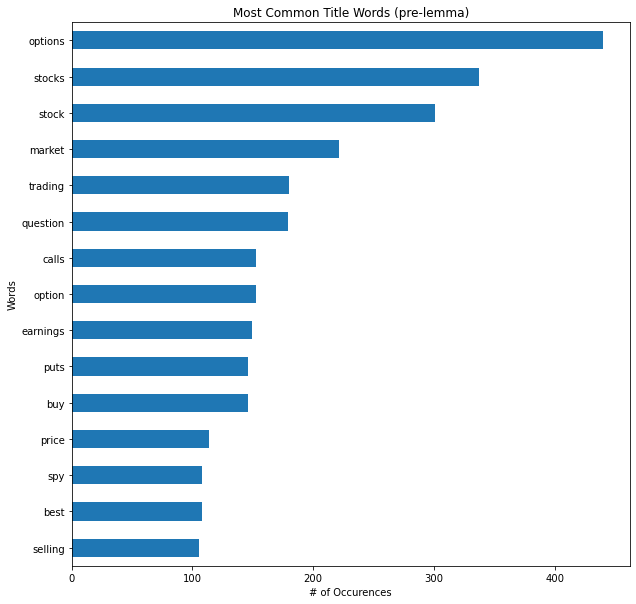

In [357]:
plt.figure(figsize=(10,10))
title_cvec0.sum(axis=0).sort_values(ascending=True).tail(15).plot(kind='barh').set(title='Most Common Title Words (pre-lemma)',xlabel='# of Occurences',ylabel='Words');

**15 Most Common Bigrams - Title (prior to lemma)**

In [358]:
cvec05 = CountVectorizer(
    stop_words='english',
    ngram_range=(2,2)
)
cvec05.fit(df['no_cont_title'])
csr = cvec05.transform(df['no_cont_title'])
title_cvec05 = pd.DataFrame(csr.todense(), columns=cvec05.get_feature_names())

In [359]:
#15 most common bigrams
title_cvec05.sum(axis=0).sort_values(ascending=False)[:15].index

Index(['stock market', 'options trading', 'covered calls', 'wash sale',
       'credit spread', 'russia ukraine', 'long term', 'strike price',
       'deep itm', 'need help', 'stocks daily', 'new options', 'selling puts',
       'earnings report', 'iron condor'],
      dtype='object')

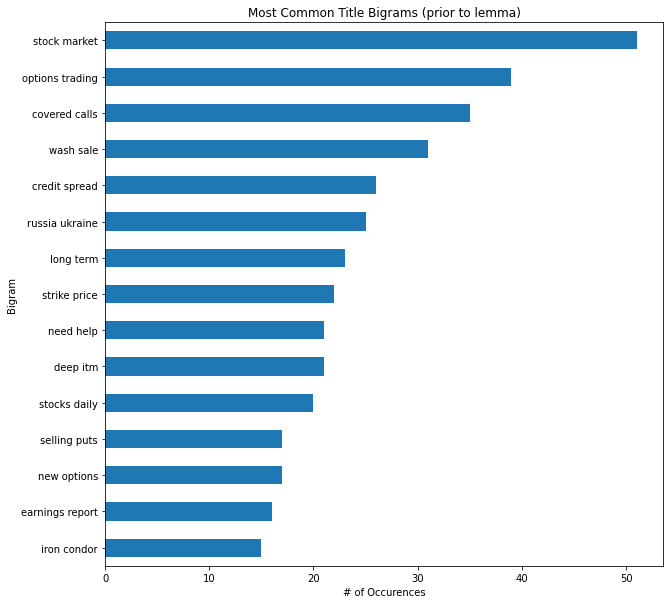

In [360]:
plt.figure(figsize=(10,10))
title_cvec05.sum(axis=0).sort_values(ascending=True).tail(15).plot(kind='barh').set(title='Most Common Title Bigrams (prior to lemma)',xlabel='# of Occurences',ylabel='Bigram');

**Lemma / Stemma Functions**

In [361]:
def lemma(str):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in str]
# with help from GA NLP1 lesson

In [362]:
def stemma(str):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in str]
# with help from GA NLP1 lesson

**Lemma / Stemma Titles**

In [363]:
 df['tokenized_title'] = df['no_cont_title'].apply(word_tokenize)

In [364]:
 df['tokenized_selftext'] = df['no_cont_selftext'].apply(word_tokenize)

In [365]:
df['lemma_title'] = df['tokenized_title'].apply(lemma) # Lemmatizes but gives a list
df['lemma_title'] = df['lemma_title'].apply(lambda x: ' '.join([str(word) for word in x])) # From list to a string # Converts back to string
#df['lemma_title'].head()

In [366]:
df['stemma_title'] = df['tokenized_title'].apply(lemma) # Stemma title but gives a list
df['stemma_title'] = df['stemma_title'].apply(lambda x: ' '.join([str(word) for word in x])) # From list to a string # Converts back to string
#df['stemma_title'].head()

**Lemma / Stemma Selftext (post)**

In [367]:
df['lemma_selftext'] = df['tokenized_selftext'].apply(lemma) # Lemmatizes but gives a list
df['lemma_selftext'] = [' '.join(map(str, word)) for word in df['lemma_selftext']] # From list to a string # Converts back to string
#df['lemma_selftext'].head()

In [368]:
df['stemma_selftext'] = df['tokenized_selftext'].apply(lemma) # Stemma title but gives a list
df['stemma_selftext'] = [' '.join(map(str, word)) for word in df['stemma_selftext']] # From list to a string # Converts back to string
#df['stemma_selftext'].head()

**CountVectorize Title (lemma)**

In [369]:
cvec1 = CountVectorizer(
    stop_words='english',
     # ngram_range=(2,2)
)
cvec1.fit(df['lemma_title'])
csr = cvec1.transform(df['lemma_title'])
title_cvec1 = pd.DataFrame(csr.todense(), columns=cvec1.get_feature_names())

#with help from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [370]:
title_cvec1.head()

,00,000,01,010,02,04,04th,06,07,0830,...,zuckerberg,zutaten,দরজ,৭০০০,まだ掲示板に残ってる奴とかいるのかね,万事达,全自动交易,复盘和展望,最新动向,雑談会
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**15 Most Common Words - Title (lemma)**

In [371]:
#15 most common words
title_cvec1.sum(axis=0).sort_values(ascending=False)[:15].index

Index(['stock', 'option', 'market', 'question', 'trading', 'earnings', 'buy',
       'options', 'spread', 'price', 'stocks', 'spy', 'best', 'short',
       'selling'],
      dtype='object')

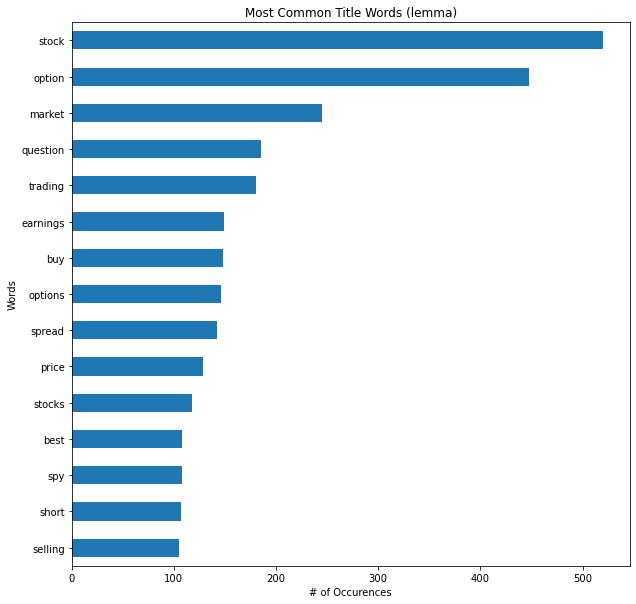

In [372]:
plt.figure(figsize=(10,10))
title_cvec1.sum(axis=0).sort_values(ascending=True).tail(15).plot(kind='barh').set(title='Most Common Title Words (lemma)',xlabel='# of Occurences',ylabel='Words');

**15 Most Common Bigrams - Title (lemma)**

In [373]:
cvec2 = CountVectorizer(
    stop_words='english',
    ngram_range=(2,2)
)
cvec2.fit(df['lemma_title'])
csr = cvec2.transform(df['lemma_title'])
title_cvec2 = pd.DataFrame(csr.todense(), columns=cvec2.get_feature_names())

In [374]:
#15 most common bigrams
title_cvec2.sum(axis=0).sort_values(ascending=False)[:15].index

Index(['stock market', 'wash sale', 'credit spread', 'option trading',
       'russia ukraine', 'strike price', 'long term', 'deep itm', 'need help',
       'iron condor', 'debit spread', 'stocks daily', 'options trading',
       'earnings report', 'new option'],
      dtype='object')

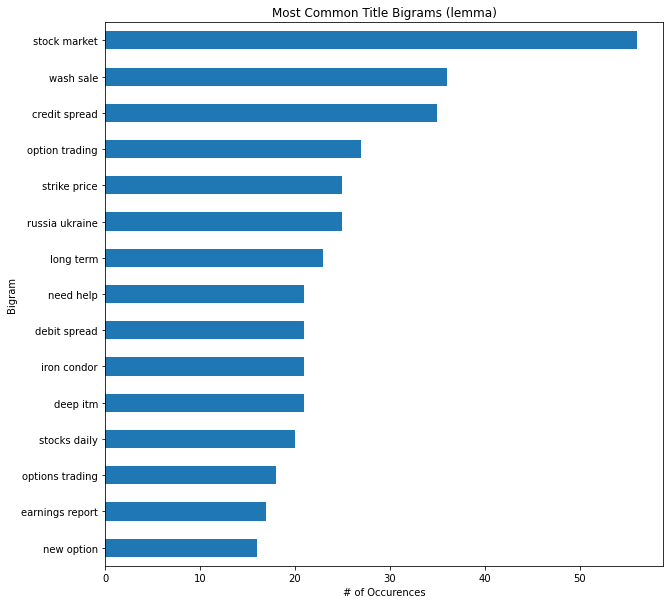

In [375]:
plt.figure(figsize=(10,10))
title_cvec2.sum(axis=0).sort_values(ascending=True).tail(15).plot(kind='barh').set(title='Most Common Title Bigrams (lemma)',xlabel='# of Occurences',ylabel='Bigram');

**CountVectorize Title (stemma)**

In [376]:
cvec3 = CountVectorizer(
    stop_words='english',
     # ngram_range=(2,2)
)
cvec3.fit(df['stemma_title'])
csr = cvec3.transform(df['stemma_title'])
title_cvec3 = pd.DataFrame(csr.todense(), columns=cvec3.get_feature_names())

In [377]:
title_cvec3.head()

,00,000,01,010,02,04,04th,06,07,0830,...,zuckerberg,zutaten,দরজ,৭০০০,まだ掲示板に残ってる奴とかいるのかね,万事达,全自动交易,复盘和展望,最新动向,雑談会
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**15 Most Common Words - Title (stemma)**

In [378]:
#15 most common words
title_cvec3.sum(axis=0).sort_values(ascending=False)[:15].index

Index(['stock', 'option', 'market', 'question', 'trading', 'earnings', 'buy',
       'options', 'spread', 'price', 'stocks', 'spy', 'best', 'short',
       'selling'],
      dtype='object')

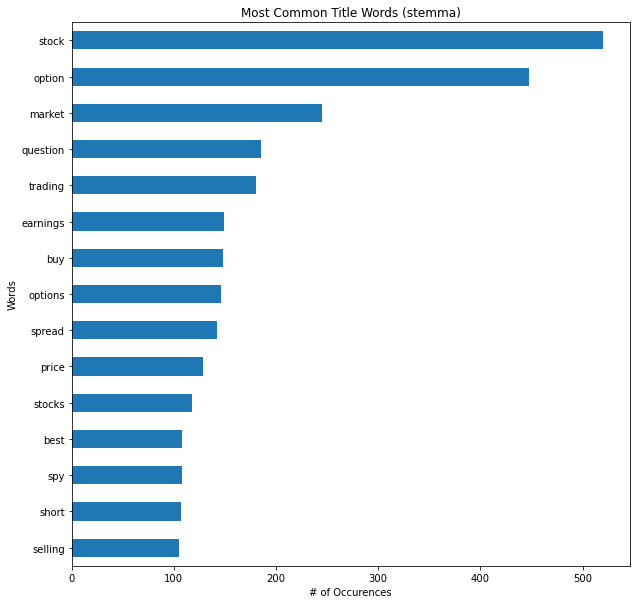

In [379]:
plt.figure(figsize=(10,10))
title_cvec3.sum(axis=0).sort_values(ascending=True).tail(15).plot(kind='barh').set(title='Most Common Title Words (stemma)',xlabel='# of Occurences',ylabel='Words');

**15 Most Common Bigrams - Title (stemma)**

In [380]:
cvec4 = CountVectorizer(
    stop_words='english',
    ngram_range=(2,2)
)
cvec4.fit(df['lemma_title'])
csr = cvec4.transform(df['lemma_title'])
title_cvec4 = pd.DataFrame(csr.todense(), columns=cvec4.get_feature_names())

In [381]:
#15 most common bigrams
title_cvec4.sum(axis=0).sort_values(ascending=False)[:15].index

Index(['stock market', 'wash sale', 'credit spread', 'option trading',
       'russia ukraine', 'strike price', 'long term', 'deep itm', 'need help',
       'iron condor', 'debit spread', 'stocks daily', 'options trading',
       'earnings report', 'new option'],
      dtype='object')

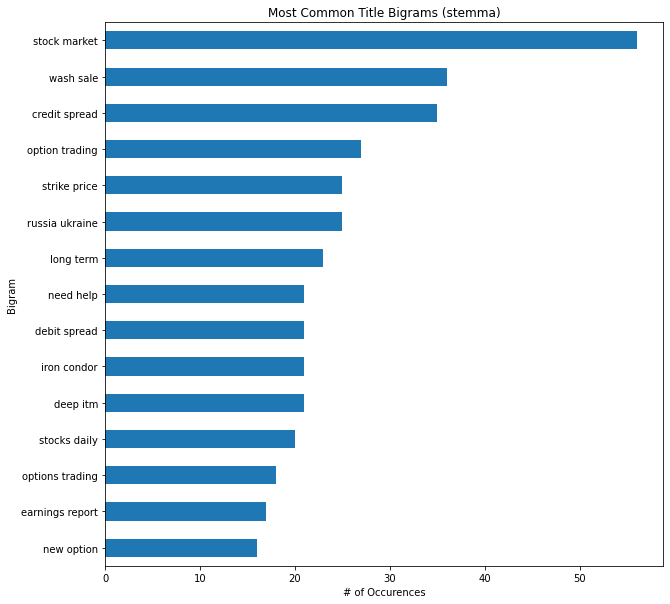

In [382]:
plt.figure(figsize=(10,10))
title_cvec4.sum(axis=0).sort_values(ascending=True).tail(15).plot(kind='barh').set(title='Most Common Title Bigrams (stemma)',xlabel='# of Occurences',ylabel='Bigram');

### 2.3.2 Sentiment Analysis

**by Title**

In [383]:
def title_sentiment(row):
    analyzer = SentimentIntensityAnalyzer()
    res = analyzer.polarity_scores(row)
    return pd.Series([res['neg'], res['neu'], res['pos'], res['compound']])

df[['t_neg','t_neu','t_pos','t_compound']] = df['title'].apply(title_sentiment)

# with help from https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [384]:
print(f"Average Title Positive Score (r/Options): {round(df[df['subreddit']==0]['t_pos'].mean(),2)}")
print(f"Average Title Positive Scoring (r/Stocks): {round(df[df['subreddit']==1]['t_pos'].mean(),2)}")
print('---')
print(f"Average Title Negative Score (r/Options): {round(df[df['subreddit']==0]['t_neg'].mean(),2)}")
print(f"Average Title Negative Score (r/Stocks): {round(df[df['subreddit']==1]['t_neg'].mean(),2)}")
print('---')
print(f"Average Title Neutral Score (r/Options): {round(df[df['subreddit']==0]['t_neu'].mean(),2)}")
print(f"Average Title Neutral Score (r/Stocks): {round(df[df['subreddit']==1]['t_neu'].mean(),2)}")
print('---')
print(f"Average Title Compound Score (r/Options): {round(df[df['subreddit']==0]['t_compound'].mean(),2)}")
print(f"Average Title Compound Score (r/Stocks): {round(df[df['subreddit']==1]['t_compound'].mean(),2)}")
print('---')

Average Title Positive Score (r/Options): 0.09
Average Title Positive Scoring (r/Stocks): 0.09
---
Average Title Negative Score (r/Options): 0.05
Average Title Negative Score (r/Stocks): 0.05
---
Average Title Neutral Score (r/Options): 0.86
Average Title Neutral Score (r/Stocks): 0.85
---
Average Title Compound Score (r/Options): 0.07
Average Title Compound Score (r/Stocks): 0.05
---


**by SelfText (Post)**

In [385]:
def selftext_sentiment(row):
    analyzer = SentimentIntensityAnalyzer()
    res = analyzer.polarity_scores(row)
    return pd.Series([res['neg'], res['neu'], res['pos'], res['compound']])

df[['s_neg','s_neu','s_pos','s_compound']] = df['selftext'].apply(selftext_sentiment)

# with help from https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [386]:
print(f"Average Title Positive Score (r/Options): {round(df[df['subreddit']==0]['s_pos'].mean(),2)}")
print(f"Average Title Positive Scoring (r/Stocks): {round(df[df['subreddit']==1]['s_pos'].mean(),2)}")
print('---')
print(f"Average Title Negative Score (r/Options): {round(df[df['subreddit']==0]['s_neg'].mean(),2)}")
print(f"Average Title Negative Score (r/Stocks): {round(df[df['subreddit']==1]['s_neg'].mean(),2)}")
print('---')
print(f"Average Title Neutral Score (r/Options): {round(df[df['subreddit']==0]['s_neu'].mean(),2)}")
print(f"Average Title Neutral Score (r/Stocks): {round(df[df['subreddit']==1]['s_neu'].mean(),2)}")
print('---')
print(f"Average Title Compound Score (r/Options): {round(df[df['subreddit']==0]['s_compound'].mean(),2)}")
print(f"Average Title Compound Score (r/Stocks): {round(df[df['subreddit']==1]['s_compound'].mean(),2)}")
print('---')

Average Title Positive Score (r/Options): 0.06
Average Title Positive Scoring (r/Stocks): 0.04
---
Average Title Negative Score (r/Options): 0.03
Average Title Negative Score (r/Stocks): 0.02
---
Average Title Neutral Score (r/Options): 0.77
Average Title Neutral Score (r/Stocks): 0.93
---
Average Title Compound Score (r/Options): 0.2
Average Title Compound Score (r/Stocks): 0.16
---


In [387]:
option_sent= round(df[df['subreddit']==0]['s_pos'].mean(),2), round(df[df['subreddit']==0]['s_neg'].mean(),2),round(df[df['subreddit']==0]['s_neu'].mean(),2),round(df[df['subreddit']==0]['s_compound'].mean(),2)
stock_sent = round(df[df['subreddit']==1]['s_pos'].mean(),2), round(df[df['subreddit']==1]['s_neg'].mean(),2),round(df[df['subreddit']==1]['s_neu'].mean(),2), round(df[df['subreddit']==1]['s_compound'].mean(),2)

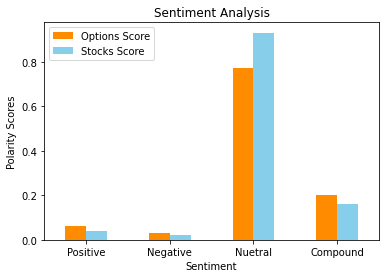

In [388]:
sentiment = {'Options Score': option_sent, 'Stocks Score': stock_sent}
result = pd.DataFrame(sentiment) 
result.plot.bar(color= [ 'darkorange','skyblue'])
plt.xticks([0, 1, 2, 3], ["Positive", "Negative", "Nuetral", "Compound"],  rotation = 0)
plt.xlabel('Sentiment')
plt.ylabel('Polarity Scores')
plt.legend(loc = 'best')
plt.title('Sentiment Analysis')
plt.show()

In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998 entries, 0 to 3997
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                3998 non-null   object 
 1   author               3998 non-null   object 
 2   selftext             3998 non-null   object 
 3   media_only           3998 non-null   bool   
 4   num_comments         3998 non-null   int64  
 5   subreddit            3998 non-null   int64  
 6   created_utc          3998 non-null   int64  
 7   title_length         3998 non-null   int64  
 8   title_word_count     3998 non-null   int64  
 9   selftext_length      3998 non-null   int64  
 10  selftext_word_count  3998 non-null   int64  
 11  no_cont_title        3998 non-null   object 
 12  no_cont_selftext     3998 non-null   object 
 13  tokenized_title      3998 non-null   object 
 14  tokenized_selftext   3998 non-null   object 
 15  lemma_title          3998 non-null   o

**Saving Cleaned Data**

In [390]:

df.to_csv('../data/clean_data/reddit_content_clean.csv')    
